In [1]:
# Cell 1 - Preflight: imports, basic checks, config snapshot
import os, sys, json, math, gc, warnings
from pathlib import Path
from datetime import date
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ML & DL
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, mean_squared_error)
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

print("Environment check:")
print(" Python:", sys.version.splitlines()[0])
print(" pandas:", pd.__version__, " numpy:", np.__version__)
print(" lightgbm:", lgb.__version__, " tensorflow:", tf.__version__)


Environment check:
 Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
 pandas: 2.3.3  numpy: 2.2.6
 lightgbm: 4.6.0  tensorflow: 2.20.0


In [2]:
# Cell 2 - Configuration (edit paths if needed)
OVERVIEW_XLSX = r"C:\Users\KIIT\Downloads\all_companies_overview.xlsx"
BALANCE_XLSX  = r"C:\Users\KIIT\Downloads\all_companies_balancesheet.xlsx"
PRICE_FOLDER  = r"C:\Users\KIIT\Downloads\cleaned"   # folder of CSVs (one per ticker)
OUTPUT_DIR    = r"C:\Users\KIIT\Downloads\predictions_output"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Modeling config
PRED_HORIZON = 3           # predict movement after 3 days
THRESHOLD = 0.0            # threshold for up (0 => any positive return)
MIN_DAYS_PER_TICKER = 100  # filter tickers with fewer rows
LOOKBACK = 60              # LSTM lookback days
LSTM_UNITS = 64
EMBED_DIM = 32
LSTM_BATCH = 128
LSTM_EPOCHS = 25

LGB_PARAMS_CLASS = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'learning_rate':0.02,
    'num_leaves':64,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'min_data_in_leaf':20,
    'n_jobs':-1,
    'verbose':-1
}
LGB_PARAMS_REG = LGB_PARAMS_CLASS.copy()
LGB_PARAMS_REG.update({'objective':'regression', 'metric':'rmse'})

# reproducibility
RANDOM_STATE = 42
print("Config set; output directory:", OUTPUT_DIR)


Config set; output directory: C:\Users\KIIT\Downloads\predictions_output


In [3]:
# Cell 3 - Load all price CSVs into one DataFrame (robust header handling)
import glob

def read_price_csv(path):
    """Robust read for per-ticker CSV: expects a Date column + price columns."""
    df = pd.read_csv(path, low_memory=False)
    cols = {c.lower(): c for c in df.columns}
    # normalize date
    date_col = None
    for c in cols:
        if 'date' == c or 'dt' == c or 'timestamp' in c:
            date_col = cols[c]; break
    if date_col is None:
        # try first column as date
        date_col = df.columns[0]
    df = df.rename(columns={date_col:'Date'})
    # find close
    close_col = None
    for k in ('close','adj close','close_price','closeprice'):
        if k in cols:
            close_col = cols[k]; break
    if close_col is None:
        # pick numeric column besides Date as Close
        for c in df.columns:
            if c!='Date' and pd.api.types.is_numeric_dtype(df[c]):
                close_col = c; break
    df = df.rename(columns={close_col:'Close'})
    # ensure ticker column
    if 'Ticker' not in df.columns:
        ticker = Path(path).stem
        df['Ticker'] = ticker.upper()
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[['Date','Ticker','Close'] + [c for c in df.columns if c not in ['Date','Ticker','Close']]]
    df = df.dropna(subset=['Date','Close']).sort_values(['Ticker','Date']).reset_index(drop=True)
    df['Ticker'] = df['Ticker'].astype(str).str.upper().str.strip()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    return df

# read all csvs
csv_files = glob.glob(os.path.join(PRICE_FOLDER, "*.csv"))
print("Found price files:", len(csv_files))
price_frames = []
for f in tqdm(csv_files, desc="Reading price files"):
    try:
        df = read_price_csv(f)
        if len(df) >= 10:
            price_frames.append(df)
    except Exception as e:
        print("Failed to read:", f, e)

prices = pd.concat(price_frames, ignore_index=True, sort=False)
print("Total price rows:", len(prices), "unique tickers:", prices['Ticker'].nunique())

# filter tickers with sufficient history
counts = prices.groupby('Ticker').size().reset_index(name='n')
good = counts[counts['n'] >= MIN_DAYS_PER_TICKER]['Ticker'].tolist()
prices = prices[prices['Ticker'].isin(good)].reset_index(drop=True)
print("Tickers retained (>= MIN_DAYS_PER_TICKER):", len(good))


Found price files: 2061


Reading price files: 100%|█████████████████████████████████████████████████████████| 2061/2061 [00:58<00:00, 35.39it/s]


Total price rows: 6592834 unique tickers: 2055
Tickers retained (>= MIN_DAYS_PER_TICKER): 2008


In [4]:
# Cell 4 - Read overview & balance book (all sheets combined)
def read_all_sheets(path):
    sheets = pd.read_excel(path, sheet_name=None, engine='openpyxl')
    frames = []
    for sname, df in sheets.items():
        if df is None or df.shape[0]==0: continue
        df = df.copy()
        df['_sheet_name'] = sname
        frames.append(df)
    if frames:
        return pd.concat(frames, ignore_index=True, sort=False)
    else:
        return pd.DataFrame()

overview = read_all_sheets(OVERVIEW_XLSX)
balances = read_all_sheets(BALANCE_XLSX)
print("Overview rows:", len(overview), "Balances rows:", len(balances))

# Try normalize ticker column if exists
def normalize_ticker_col(df):
    df = df.copy()
    cols = [c.lower() for c in df.columns]
    for cand in ['yahoo_ticker','ticker','symbol','company','code']:
        if cand in cols:
            df['Ticker'] = df.iloc[:, cols.index(cand)].astype(str).str.upper().str.strip()
            return df
    # fallback: if sheet name provided earlier
    if '_sheet_name' in df.columns:
        df['Ticker'] = df['_sheet_name'].astype(str).str.upper().str.strip()
    return df

overview = normalize_ticker_col(overview)
balances = normalize_ticker_col(balances)
print("Overview tickers (sample):", overview['Ticker'].dropna().unique()[:10])


Overview rows: 2060 Balances rows: 9997
Overview tickers (sample): ['20MICRONS.NS' '3MINDIA.NS' '21STCENMGM.NS' '3PLAND.NS' '5PAISA.NS'
 '360ONE.NS' '63MOONS.NS' 'AADHARHFC.NS' 'AAKASH.NS' 'A2ZINFRA.NS']


In [5]:
# Cell 5 - Technical indicators per ticker
def add_tech_indicators(group):
    g = group.sort_values('Date').reset_index(drop=True).copy()
    g['Close'] = pd.to_numeric(g['Close'], errors='coerce')
    g['Ret1'] = g['Close'].pct_change(1)
    g['Ret2'] = g['Close'].pct_change(2)
    g['Ret3'] = g['Close'].pct_change(3)
    g['MA5'] = g['Close'].rolling(5, min_periods=1).mean()
    g['MA10'] = g['Close'].rolling(10, min_periods=1).mean()
    g['MA20'] = g['Close'].rolling(20, min_periods=1).mean()
    g['STD10'] = g['Ret1'].rolling(10, min_periods=1).std()
    g['Momentum5'] = g['Close'] / g['MA5'] - 1
    # RSI (simple)
    delta = g['Close'].diff()
    up = delta.clip(lower=0).rolling(14).mean()
    down = -delta.clip(upper=0).rolling(14).mean()
    g['RSI'] = 100 - (100 / (1 + up/(down+1e-9)))
    # Bollinger width
    bb_mid = g['Close'].rolling(20).mean()
    bb_std = g['Close'].rolling(20).std()
    g['BB_width'] = 2 * bb_std
    return g

frames = []
for t, g in tqdm(prices.groupby('Ticker'), desc="Computing technicals"):
    frames.append(add_tech_indicators(g))
data = pd.concat(frames, ignore_index=True, sort=False)
print("Data after technicals:", data.shape)


Computing technicals: 100%|███████████████████████████████████████████████████████| 2008/2008 [00:14<00:00, 141.90it/s]


Data after technicals: (6590587, 18)


In [6]:
# Cell 6 - Merge overview static fields and balance data via merge_asof when ReportDate exists
df = data.copy()

# Merge overview on Ticker (static)
if 'Ticker' in overview.columns:
    # take first rows per ticker (static)
    ov_small = overview.groupby('Ticker', as_index=False).first()
    df = df.merge(ov_small.add_prefix('ov_'), left_on='Ticker', right_on='ov_Ticker', how='left')
    # drop duplicate prefix column
    if 'ov_Ticker' in df.columns: df.drop(columns=['ov_Ticker'], inplace=True)

# For balances: if they have ReportDate column, merge_asof per ticker; else broadcast first row
date_cols_bal = [c for c in balances.columns if 'date' in c.lower() or 'period' in c.lower() or 'report' in c.lower()]
balances = balances.copy()
if date_cols_bal:
    balances = balances.rename(columns={date_cols_bal[0]:'ReportDate'})
    balances['ReportDate'] = pd.to_datetime(balances['ReportDate'], errors='coerce')
    balances_sorted = balances.dropna(subset=['ReportDate']).sort_values(['Ticker','ReportDate'])
else:
    balances_sorted = balances.copy()

merged_frames = []
for t, g in tqdm(df.groupby('Ticker'), desc="Merging balances"):
    g = g.sort_values('Date').reset_index(drop=True)
    b = balances_sorted[balances_sorted['Ticker']==t].copy()
    if not b.empty and 'ReportDate' in b.columns:
        b = b.sort_values('ReportDate')
        merged = pd.merge_asof(g, b, left_on='Date', right_on='ReportDate', direction='backward')
    else:
        if not b.empty:
            row0 = b.iloc[0].to_dict()
            for col,val in row0.items():
                if col!='Ticker':
                    g[col] = val
        merged = g
    merged_frames.append(merged)
merged = pd.concat(merged_frames, ignore_index=True, sort=False)
print("Merged shape:", merged.shape)


Merging balances: 100%|███████████████████████████████████████████████████████████| 2008/2008 [00:07<00:00, 281.46it/s]


Merged shape: (6590587, 29)


In [7]:
# Cell 7 - compute simple ratios heuristically
def to_num(x): return pd.to_numeric(x, errors='coerce')
m = merged.copy()
cols_low = {c.lower():c for c in m.columns}

def find_col(keys):
    for k in keys:
        for cl,c in cols_low.items():
            if k in cl:
                return c
    return None

total_assets_col = find_col(['total asset'])
total_liab_col = find_col(['total liab','liabilities'])
net_debt_col = find_col(['net debt'])
revenue_col = find_col(['revenue'])
netprofit_col = find_col(['net profit','netincome','net income'])

if total_assets_col and total_liab_col:
    m['DebtToAssets'] = to_num(m[total_liab_col]) / (to_num(m[total_assets_col]) + 1e-9)
if net_debt_col and total_assets_col:
    m['NetDebtToAssets'] = to_num(m[net_debt_col]) / (to_num(m[total_assets_col]) + 1e-9)
if revenue_col and netprofit_col:
    m['ProfitMargin'] = to_num(m[netprofit_col]) / (to_num(m[revenue_col]) + 1e-9)

# Ensure Close exists and drop rows missing it
m = m.dropna(subset=['Close']).reset_index(drop=True)
merged = m.copy()
print("Fundamental ratio columns:", [c for c in merged.columns if c.lower().startswith('debt') or 'profit' in c.lower()])


Fundamental ratio columns: ['ov_Net_Profit']


In [8]:
# Cell 8 - Create targets
df = merged.sort_values(['Ticker','Date']).reset_index(drop=True)
df['FutureClose'] = df.groupby('Ticker')['Close'].shift(-PRED_HORIZON)
df['Target3_ret'] = (df['FutureClose'] / df['Close']) - 1.0
df['Target3_class'] = (df['Target3_ret'] > THRESHOLD).astype(int)
df = df.dropna(subset=['FutureClose']).reset_index(drop=True)
print("Rows after target creation:", len(df))
print("Class balance:", df['Target3_class'].value_counts(normalize=True).to_dict())


Rows after target creation: 6584563
Class balance: {0: 0.5392260655718535, 1: 0.46077393442814657}


In [9]:
# Cell 9 - select features and prepare X,y
# Use numeric features from technicals and derived fundamentals + some overview fields
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
# exclude identifiers & targets
exclude = set(['FutureClose','Target3_ret','Target3_class'])
feature_cols = [c for c in numeric_cols if c not in exclude and c not in ['Date']]
print("Candidate numeric features count:", len(feature_cols))

# Optionally drop features with too many NaNs
na_pct = df[feature_cols].isna().mean()
keep_feats = na_pct[na_pct < 0.6].index.tolist()
feature_cols = keep_feats
print("Features kept (after >60% missing filter):", len(feature_cols))

# fill na with 0 (or consider median imputation)
X = df[feature_cols].fillna(0)
y_class = df['Target3_class'].astype(int)
y_reg = df['Target3_ret'].astype(float)

# ticker id (categorical) - handy for LGB and LSTM embedding
df['TickerID'] = df['Ticker'].astype('category').cat.codes
ticker_to_id = dict(enumerate(df['Ticker'].astype('category').cat.categories))
print("Ticker count:", len(ticker_to_id))


Candidate numeric features count: 21
Features kept (after >60% missing filter): 15
Ticker count: 2008


In [10]:
# -------------------- Cell 10 (FIXED) --------------------
# Time-based split and baseline LightGBM trains (regression & classification)
import numpy as np
from sklearn.metrics import mean_squared_error

# Time split by date (global)
split_date = df['Date'].quantile(0.8)
train_mask = df['Date'] <= split_date
test_mask = df['Date'] > split_date

X_train = X[train_mask]
X_test  = X[test_mask]
ycla_train = y_class[train_mask]
ycla_test  = y_class[test_mask]
yreg_train = y_reg[train_mask]
yreg_test  = y_reg[test_mask]

print("Train rows:", len(X_train), "Test rows:", len(X_test), "split_date:", split_date)

# Scale numeric features for LGB/regression (LGB can handle unscaled, but scaling helps LSTM & stacking)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)
joblib.dump(scaler, os.path.join(OUTPUT_DIR, 'feature_scaler.pkl'))

# -------------------- LightGBM regression (predict 3-day return) --------------------
lgb_reg = lgb.LGBMRegressor(**LGB_PARAMS_REG, n_estimators=1000)
print("Training LightGBM regressor...")
lgb_reg.fit(X_train_scaled, yreg_train,
            eval_set=[(X_test_scaled, yreg_test)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

yreg_pred = lgb_reg.predict(X_test_scaled)

# Compute RMSE in a way compatible with all sklearn versions
mse = mean_squared_error(yreg_test.values.astype(float), yreg_pred.astype(float))
rmse = np.sqrt(mse)
print("LGB Regression RMSE (3-day ret):", rmse)

# -------------------- LightGBM classification (predict up/down) --------------------
lgb_clf = lgb.LGBMClassifier(**LGB_PARAMS_CLASS, n_estimators=1000)
# handle class imbalance: compute scale_pos_weight if possible
pos = int(ycla_train.sum())
neg = int(len(ycla_train) - pos)
if pos > 0:
    scale_pos_weight = neg / max(pos, 1)
    lgb_clf.set_params(scale_pos_weight=scale_pos_weight)
    print("scale_pos_weight set to:", scale_pos_weight)

print("Training LightGBM classifier...")
lgb_clf.fit(X_train_scaled, ycla_train,
            eval_set=[(X_test_scaled, ycla_test)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

# Predict & evaluate classifier
ycla_prob = lgb_clf.predict_proba(X_test_scaled)[:, 1]
ycla_pred = (ycla_prob >= 0.5).astype(int)

print("\nLGB Classifier metrics on test:")
print("Accuracy:", accuracy_score(ycla_test, ycla_pred))
print("F1:", f1_score(ycla_test, ycla_pred))
try:
    print("ROC-AUC:", roc_auc_score(ycla_test, ycla_prob))
except Exception:
    print("ROC-AUC: could not be computed (possible single-class in test predictions).")
print(classification_report(ycla_test, ycla_pred, zero_division=0))

# Save baseline models
try:
    # booster_.save_model exists for fitted models
    lgb_reg.booster_.save_model(os.path.join(OUTPUT_DIR, 'lgb_reg_baseline.txt'))
    lgb_clf.booster_.save_model(os.path.join(OUTPUT_DIR, 'lgb_clf_baseline.txt'))
except Exception:
    # fallback to joblib if booster_.save_model not available
    joblib.dump(lgb_reg, os.path.join(OUTPUT_DIR, 'lgb_reg_baseline.pkl'))
    joblib.dump(lgb_clf, os.path.join(OUTPUT_DIR, 'lgb_clf_baseline.pkl'))

print("Saved baseline models to", OUTPUT_DIR)
# -------------------- end Cell 10 --------------------


Train rows: 5268401 Test rows: 1316162 split_date: 2022-09-27 00:00:00
Training LightGBM regressor...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.13244
LGB Regression RMSE (3-day ret): 0.13244025334020038
scale_pos_weight set to: 1.1825501248201025
Training LightGBM classifier...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.549436
[200]	valid_0's auc: 0.551505
[300]	valid_0's auc: 0.552341
[400]	valid_0's auc: 0.552891
[500]	valid_0's auc: 0.553165
[600]	valid_0's auc: 0.553497
[700]	valid_0's auc: 0.553619
[800]	valid_0's auc: 0.553882
[900]	valid_0's auc: 0.554021
[1000]	valid_0's auc: 0.554208
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.554208

LGB Classifier metrics on test:
Accuracy: 0.5131594742896392
F1: 0.6083590602734685
ROC-AUC: 0.5542078419948322
              precision    recall  f1-score   support

           0       0.59      0.26   

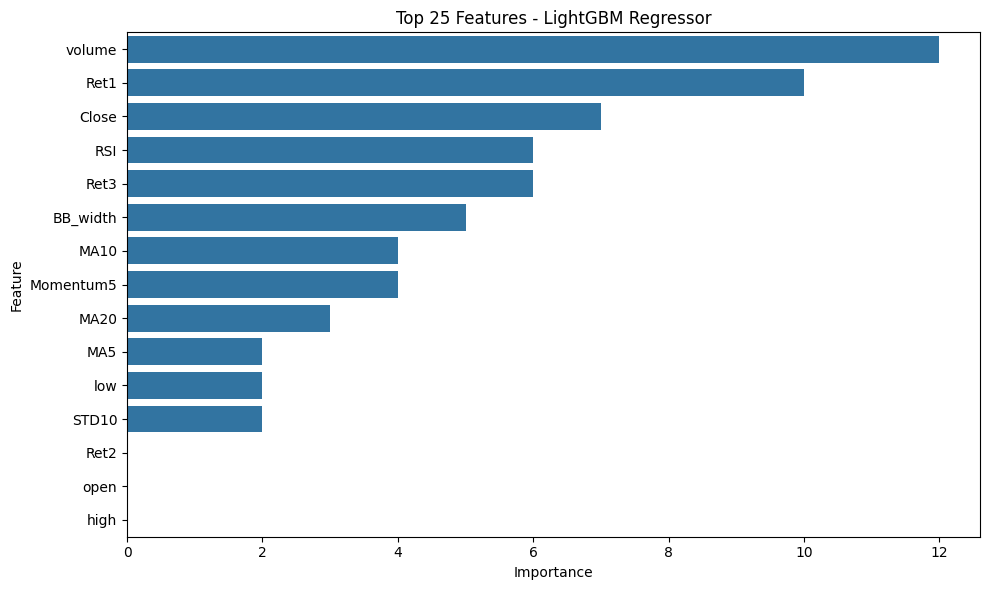

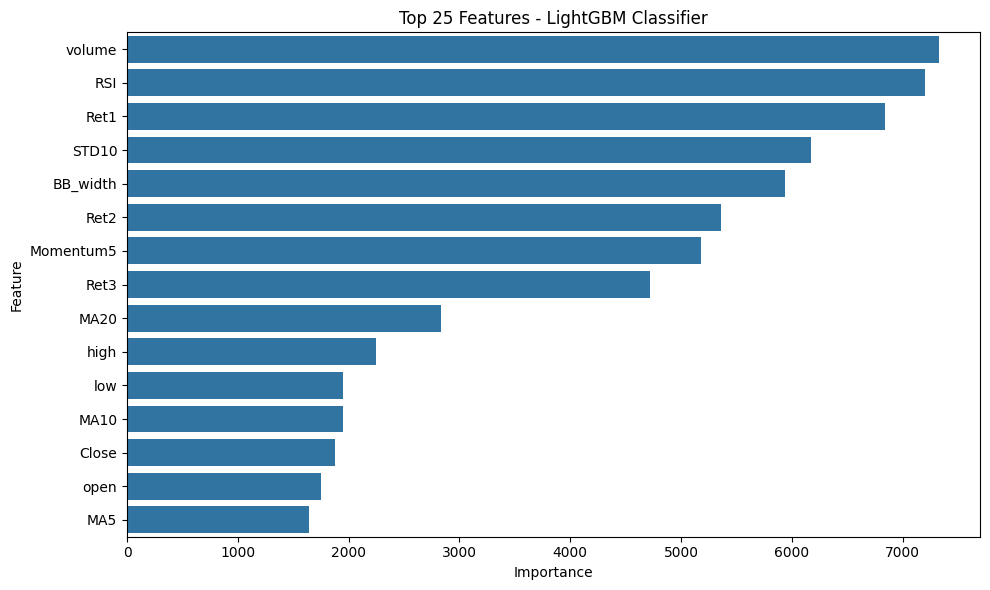

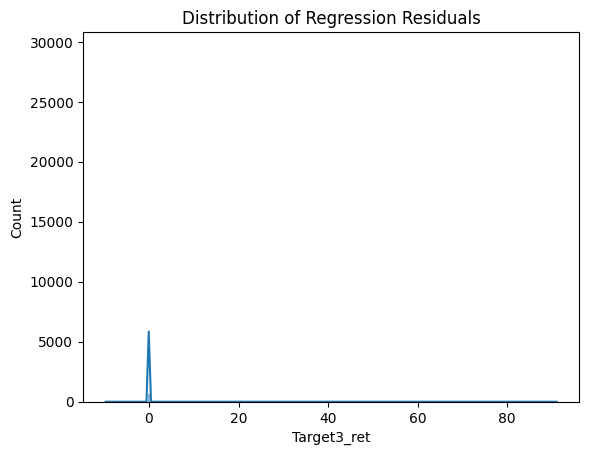

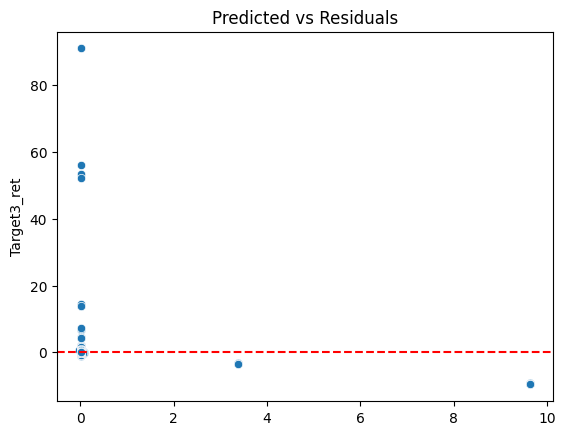

In [11]:
# -------------------- Cell 11 --------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance for both models
def plot_importance(model, title):
    imp = pd.DataFrame({
        'Feature': model.feature_name_,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=imp.head(25))
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_importance(lgb_reg, "Top 25 Features - LightGBM Regressor")
plot_importance(lgb_clf, "Top 25 Features - LightGBM Classifier")

# Regression residual diagnostics
residuals = yreg_test - yreg_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Regression Residuals")
plt.show()

sns.scatterplot(x=yreg_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Predicted vs Residuals")
plt.show()


In [12]:

# -------------------- Cell 12 --------------------
import os, joblib, time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

print("CELL 12: Safe tuning (regression) using a small sample...")

# sample fraction for tuning (5% recommended)
sample_frac = 0.05
if sample_frac < 1.0:
    X_sample, _, y_sample, _ = train_test_split(x_train_scaled, yreg_train, train_size=sample_frac, random_state=42)
else:
    X_sample, y_sample = x_train_scaled, yreg_train

param_dist = {
    'num_leaves': randint(31, 127),
    'max_depth': randint(4, 16),
    'learning_rate': uniform(0.01, 0.05),
    'feature_fraction': uniform(0.6, 0.4),
    'bagging_fraction': uniform(0.6, 0.4),
    'min_child_samples': randint(20, 120)
}

base_reg = lgb.LGBMRegressor(objective='regression', n_estimators=300, n_jobs=-1, random_state=42)

reg_search = RandomizedSearchCV(
    estimator=base_reg,
    param_distributions=param_dist,
    n_iter=10,               # small search to keep it fast
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

start = time.time()
reg_search.fit(X_sample, y_sample)
print(f"Tuning finished in {(time.time()-start)/60:.2f} minutes")

best_reg_params = reg_search.best_params_
print("Best regression params (sample search):", best_reg_params)
joblib.dump(reg_search.best_estimator_, os.path.join(OUTPUT_DIR, 'lgb_reg_search_sample.pkl'))




CELL 12: Safe tuning (regression) using a small sample...


NameError: name 'x_train_scaled' is not defined